In [2]:
%matplotlib widget
import jungfrau_utils as ju
import numpy as np
import json, h5py
import os, glob
import time
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm
from scipy.optimize import curve_fit
from IPython.display import clear_output, display
import matplotlib.colors as colors
import matplotlib.ticker as ticker
from ipyfilechooser import FileChooser
from scipy.stats.stats import pearsonr

from alvra_tools.load_data import *
from alvra_tools.channels import *
from alvra_tools.utils import *
from alvra_tools.XES_functions import *

import warnings
warnings.filterwarnings('ignore')

In [3]:
pgroup='p21211'
runnumber = 71
print ('run: {:04d}'.format(runnumber))

#############################################################
jsonfile = ''
jsonfile = glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/meta/scan.json'.format(pgroup, runnumber))[0]
titlestring = str( pgroup + ' --- ' +jsonfile.split('/')[-3])
print (jsonfile)
from sfdata import SFScanInfo
scan = SFScanInfo(jsonfile)
print ('Scan contains {} step(s), scanvar goes {:.2f} to {:.2f} {}'.format(len(scan), scan.readbacks[0], scan.readbacks[-1], scan.parameters['units'][0]))

run: 0071
/sf/alvra/data/p21211/raw/run0071-XANES_CpStRh_100ns/meta/scan.json
Scan contains 51 step(s), scanvar goes 2995.00 to 3015.00 eV


In [ ]:
threshold_low = 2
threshold_high = 10

channels_list = []

#####################################################

import sfdata.sfdatafile
sfdata.sfdatafile.ju = None
scan = SFScanInfo(jsonfile)
spectra_on, spectra_off,_,_,_,_, ROIs, Energy_eV, meta = RIXS_PumpProbe_ROIs(scan, channels_list, threshold_low, threshold_high)

Processing: run0071-XANES_CpStRh_100ns
Step 1 of 51: Processing acq0001

--------------------------------------------------------------------------------

JF02T09V03:ROI_LbDW1     2501 / 2501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
JF02T09V03:ROI_LbDW1_bkg 2501 / 2501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
JF02T09V03:ROI_LbDW2     2501 / 2501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
JF02T09V03:ROI_LbDW2_bkg 2501 / 2501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
JF02T09V03:ROI_LbUP1     2501 / 2501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
JF02T09V03:ROI_LbUP1_bkg 2501 / 2501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
JF02T09V03:ROI_LbUP2     2501 / 2501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
JF02T09V03:ROI_LbUP2_bkg 2501 / 2501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAR-CVME-TIFALL4:EvtSet  2501 / 2501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 2501 / 2501 -> 0% loss
complete channels: 9 / 9 -> 0% incomplete

--------------------------------------------------------------------------------

FEL rep rate is 100.0 Hz
Laser rep rate is 50.0 Hz (delayed or dark)
Pump scheme is 1:1


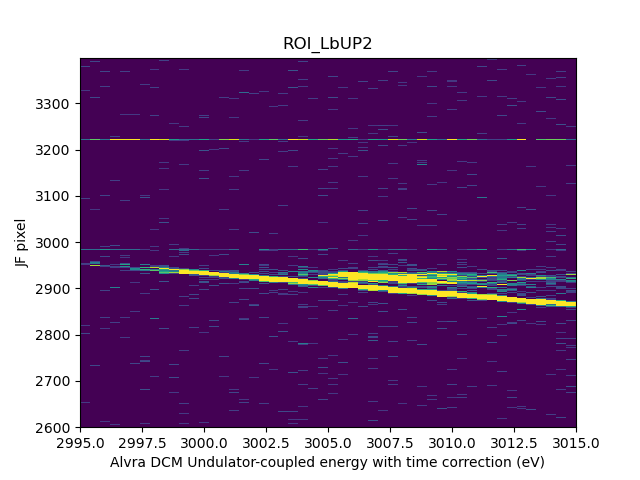

In [90]:
ROI = 'JF02T09V03:ROI_LbUP2'

bin_ = 1

vmin = None
vmax = 0.01

#######################################
matrix_off = []
for index_step in range(len(spectra_off)):
    matrix_off.append(spectra_off[index_step][ROI])#.split(':')[-1]])
plt.figure()
plt.title(ROI.split(':')[-1])
yaxis = np.arange(np.array(meta[ROI+'-roi']).flatten()[-2], np.array(meta[ROI+'-roi']).flatten()[-1], 1)
y_axis_rebin, matrix_off_rebin = plot_tool_static_2D(matrix_off, 0, yaxis, bin_)

plt.pcolormesh(Energy_eV, y_axis_rebin, np.transpose(np.asarray(matrix_off_rebin)), vmin = vmin, vmax = vmax)
plt.xlabel('{} ({})'.format(scan.parameters['name'][0],scan.parameters['units'][0]))
plt.ylabel('JF pixel')
#plt.axhline(y = 5098, color = 'r', linestyle = 'dashed')
plt.show()

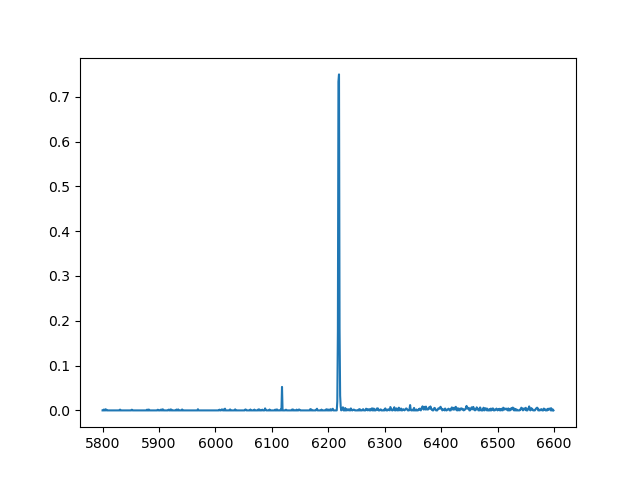

0.7499653


In [78]:
ROI = 'JF02T09V03:ROI_LbDW1'
plt.figure()
plt.plot(y_axis_rebin, spectra_off[0][ROI])
plt.show()
a = np.ptp(spectra_off[0][ROI])
print (a)

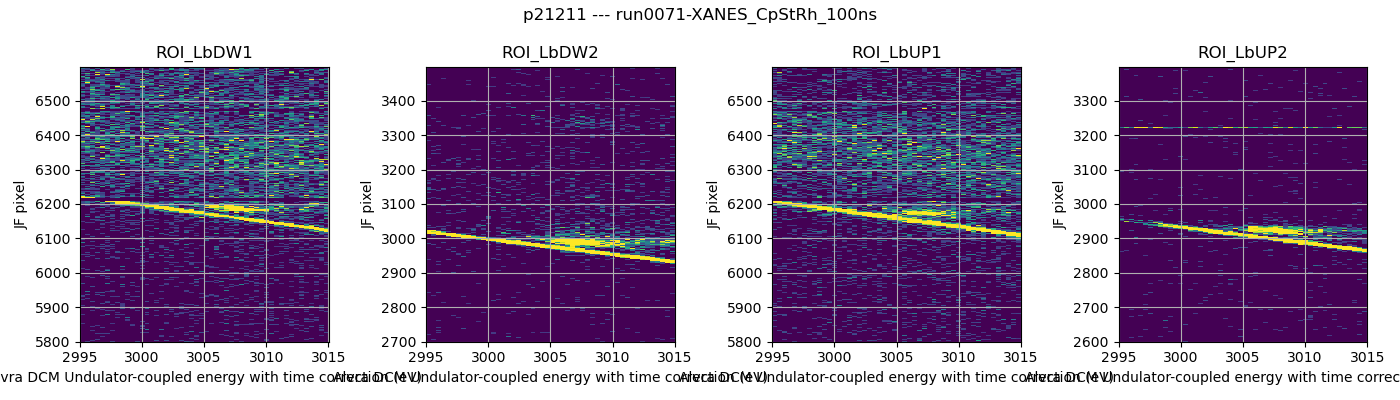

In [79]:
energy_calib = False
Loaddir = '../Claudio/Reduced_RIXS/Energy_calib/'

bin_ = 1

vmin = None
vmax = 0.01

################################################
try:
    with open(Loaddir+'calibration.pkl', 'rb') as f:
        calibration = pickle.load(f)
except:
    print ('No energy calibration file found!')

fig, axs = plt.subplots(nrows=1, ncols=len(ROIs[0::2]), figsize=(14,4))
plt.suptitle(titlestring)
for i, (key, ax) in enumerate(zip(ROIs[0::2], axs.flatten())):
    #if "bkg" in key:
    #    continue
    matrix_off = []
    for index_step in range(len(spectra_off)):
        matrix_off.append(spectra_off[index_step][key])#.split(':')[-1]])
        
    yaxis = np.arange(np.array(meta[key+'-roi']).flatten()[-2], np.array(meta[key+'-roi']).flatten()[-1], 1)
    y_axis_rebin, matrix_off_rebin = plot_tool_static_2D(matrix_off, 0, yaxis, bin_)
    
    ylabel = 'JF pixel'
    if energy_calib:
        m,b = calibration[ROI]
        y_axis_rebin = m*y_axis_rebin + b
        ylabel = 'Emission energy (eV)'
            
    plt.sca(ax)
    plt.title(key.split(':')[-1])
    plt.pcolormesh(Energy_eV, y_axis_rebin, np.transpose(np.asarray(matrix_off_rebin)), vmin = vmin, vmax = vmax)
    #plt.plot(Energy_eV, np.transpose(np.asarray(matrix_off_rebin)).sum(axis=0))
    #plt.colorbar()
    plt.ylabel(ylabel)
    #plt.ylim(3120, 3180)
    plt.grid()
    plt.xlabel('{} ({})'.format(scan.parameters['name'][0],scan.parameters['units'][0]))
plt.tight_layout()

{'JF02T09V03:ROI_LbDW1': (-0.211990986608586, 4313.047215782511),
 'JF02T09V03:ROI_LbDW2': (-0.2160590297983491, 3647.6822291991366),
 'JF02T09V03:ROI_LbUP1': (-0.19995828105914945, 4236.348087532122),
 'JF02T09V03:ROI_LbUP2': (-0.21245769510311394, 3623.3817826294485)}

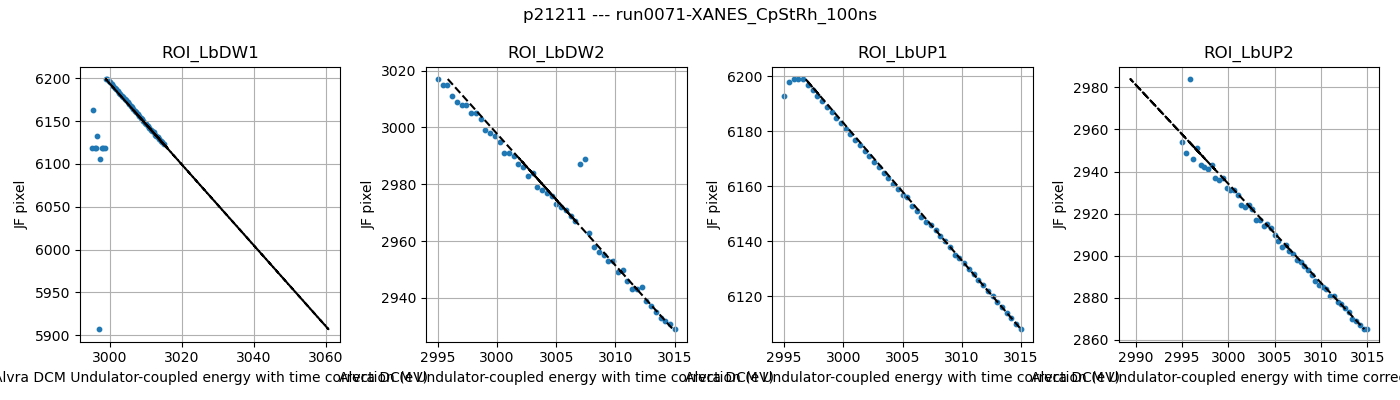

In [84]:
calibration = {}
dir2save = '../Claudio/Reduced_RIXS/Energy_calib/'

fig, axs = plt.subplots(nrows=1, ncols=len(ROIs[0::2]), figsize=(14,4))
plt.suptitle(titlestring)
import pickle
for i, (ROI, ax) in enumerate(zip(ROIs[0::2], axs.flatten())):
#for ROI in ROIs[0::2]:
    XES_axis = np.arange(np.array(meta[ROI+'-roi']).flatten()[-2], np.array(meta[ROI+'-roi']).flatten()[-1], 1)
    maxpos = []
    for index_step in range(len(spectra_off)):
        maxpos.append(np.argmax(spectra_off[index_step][ROI][:-400])+XES_axis[0])
    maxpos = np.asarray(maxpos)
    m, b = np.polyfit(maxpos[-10:], Energy_eV[-10:], 1)
    calibration[ROI]=(m,b)
    plt.sca(ax)
    plt.title(ROI.split(':')[-1])
    plt.scatter(Energy_eV, maxpos, s = 10)
    plt.plot(m*(maxpos) + b, maxpos,  '--', color='black')
    plt.xlabel('{} ({})'.format(scan.parameters['name'][0],scan.parameters['units'][0]))
    plt.ylabel('JF pixel')
    plt.tight_layout()
    plt.grid()
#calibration['JF02T09V03:ROI_LbDW1'] = (-0.19736842105263158, 4223.092105263158)
os.makedirs(dir2save, exist_ok=True)
with open(dir2save + 'calibration2.pkl', 'wb') as f:
    pickle.dump(calibration, f)   
calibration

In [ ]:
6197 3000
6121 3015

In [72]:
-0.19736842105263158*(6121) - 3015

-4223.092105263158

In [1]:
energy_calib = True
energy_loss_plot = False

Loaddir = '../Claudio/Reduced_RIXS/Energy_calib/'

bin_ = 1

vmin = None
vmax = 0.01

################################################
try:
    with open(Loaddir+'calibration2.pkl', 'rb') as f:
        calibration = pickle.load(f)
except:
    print ('No energy calibration file found!')

fig, axs = plt.subplots(nrows=1, ncols=len(ROIs[0::2]), figsize=(14,4))
plt.suptitle(titlestring)
for i, (key, ax) in enumerate(zip(ROIs[0::2], axs.flatten())):
    #if "bkg" in key:
    #    continue
    matrix_off = []
    for index_step in range(len(spectra_off)):
        matrix_off.append(spectra_off[index_step][key])#.split(':')[-1]])
        
    yaxis = np.arange(np.array(meta[key+'-roi']).flatten()[-2], np.array(meta[key+'-roi']).flatten()[-1], 1)
    y_axis_rebin, matrix_off_rebin = plot_tool_static_2D(matrix_off, 0, yaxis, bin_)
    
    ylabel = 'JF pixel'
    plt.sca(ax)
    plt.title(key.split(':')[-1])
    if energy_calib:
        m,b = calibration[key]
        y_axis_rebin = m*y_axis_rebin + b
        ylabel = 'Emission energy (eV)'
        print (key, m,b)
    if energy_loss_plot:
        for index_energy in range(len(Energy_eV)):
            y_axis_rebin_EL, matrix_off_rebin_EL = energy_loss(np.asarray(matrix_off_rebin), y_axis_rebin, Energy_eV)
        y_axis_rebin = np.copy(y_axis_rebin_EL)
        matrix_off_rebin = np.copy(matrix_off_rebin_EL)
        ylabel = 'Energy loss (eV)'
    
    #plt.pcolormesh(Energy_eV, y_axis_rebin_EL, np.transpose(np.asarray(matrix_off_rebin_EL)), vmin = vmin, vmax = vmax)
    plt.pcolormesh(Energy_eV, y_axis_rebin, np.transpose(np.asarray(matrix_off_rebin)), vmin = vmin, vmax = vmax)
    #plt.plot(Energy_eV, np.transpose(np.asarray(matrix_off_rebin)).sum(axis=0))
    #plt.colorbar()
    plt.ylabel(ylabel)
    #plt.ylim(3120, 3180)
    plt.grid()
    plt.xlabel('{} ({})'.format(scan.parameters['name'][0],scan.parameters['units'][0]))
plt.tight_layout()

No energy calibration file found!


NameError: name 'plt' is not defined

## Load calibration parameters

In [7]:
m_all = np.loadtxt('/das/work/p19/p19262/JF_XES_calibration/223_XAS_CpRhCO2_250fs.json_m_all.txt')
b_all = np.loadtxt('/das/work/p19/p19262/JF_XES_calibration/223_XAS_CpRhCO2_250fs.json_b_all.txt')

## Check calibration

<IPython.core.display.Javascript object>


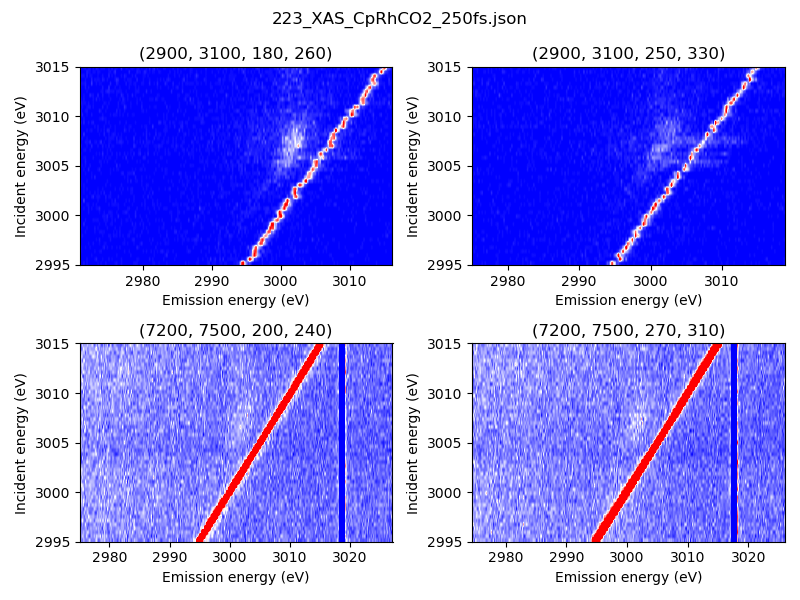

In [8]:
fig = plt.figure(figsize=(8, 6))
plt.suptitle(fc.selected_filename)

RIXSarray = [RIXS_roi1, RIXS_roi2, RIXS_roi3, RIXS_roi4]
roiarray = [roi1, roi2, roi3, roi4]

for i in range(4):
    RIXS_roi = RIXSarray[i]
    roi = roiarray[i]
    
    xaxis = np.linspace(roi[0]*m_all[i]+b_all[i], roi[1]*m_all[i]+b_all[i], roi[1]-roi[0])
    
    location = 221+i  # this is to index the position of the subplot
    ax = plt.subplot(location)
    ax.imshow(RIXS_roi,aspect = 'auto', cmap='bwr',origin='lower',\
             extent=[xaxis[0], xaxis[-1], Energy_eV[0], Energy_eV[-1]], vmin=0, vmax=100)
    ax.set_xlabel('Emission energy (eV)')
    ax.set_ylabel('Incident energy (eV)')
    ax.invert_xaxis()
    
    ax.set_title(str(roiarray[i]))
    
plt.tight_layout()